In [103]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
from functools import reduce
# import ast
# def add_spread_data(df):
#     df['spread'] = df.apply(lambda x: x['ask_price_1'] - x['bid_price_1'],axis = 1)
#     print('here')
#     df['mid'] = df.apply(lambda x: x['bid_price_1'] + (x['spread']/2),axis = 1)
#     return df
def read_market_data(fileName):
    df = pd.read_csv(fileName).fillna("")
    cols = df.columns.tolist()[0].split(';')
    fin = pd.DataFrame(df.iloc[:,0].apply(lambda x: x.split(';')).values.tolist(),columns= cols)
    to_float_cols = ['day','timestamp','bid_price_1','bid_volume_1','bid_price_2','bid_volume_2','bid_price_3','bid_volume_3','ask_price_1','ask_volume_1','ask_price_2','ask_volume_2','ask_price_3','ask_volume_3','mid_price','profit_and_loss']
    fin[to_float_cols] =  fin[to_float_cols].applymap(lambda x: float(x) if x != '' else '')
    # fin = add_spread_data(fin)
    return fin

# def read_trade_data(fileName):
#     df = pd.read_csv(fileName).fillna("")
#     cols = df.columns.tolist()[0].split(';')
#     fin = pd.DataFrame(df.iloc[:,0].apply(lambda x: x.split(';')).values.tolist(),columns= cols)
#     to_float_cols = ['day','timestamp','price','quantity']
#     fin[to_float_cols] =  fin[to_float_cols].applymap(lambda x: float(x) if x != '' else '')
#     # fin = add_spread_data(fin)
#     return fin


# def read_trade_data_modified(fileName):
#     df = pd.read_csv(fileName).fillna("")
#     cols = df.columns.tolist()[0].split(';')
#     fin = pd.DataFrame(df.iloc[:,0].apply(lambda x: x.split(';')).values.tolist(),columns= cols)
#     to_float_cols = ['timestamp','price','quantity']
#     day = 1 if '1' in fileName else ( 0 if '0' in fileName else '-1')
#     fin[to_float_cols] =  fin[to_float_cols].applymap(lambda x: float(x) if x != '' else '')
#     fin['day'] = day
#     # fin = add_spread_data(fin)
#     return fin

def split_data_by_product(df):
    markets = dict()
    products  = df['product'].unique().tolist()    
    for prod in products:
        markets[prod]= df[df['product']==prod]
    return markets

def bollinger(df,col,window=10,deviations = 2):
    df[col+"_mean"] = df[col].rolling(window = window).mean()
    df[col+"_std"] = df[col].rolling(window = window).std() * deviations
    df[col+"_hi"] = df[col+"_std"] + df[col+"_mean"]
    df[col+"_lo"] = df[col+"_mean"] - df[col+"_std"] 
    return df


# def read_log_output(fname):
#     logfile = open(fname,'r').readlines()
#     logfile = [i.strip('\n') for i in logfile if ';' in i]
#     logfile = [i[i.find('time'):] for  i in logfile]
#     logfile = [i.split('|') for  i in logfile]
#     logfile = [[item.split(';') for item in l] for l in logfile]
#     logfile = [{item[0]:item[1] for item in l} for l in logfile]
#     logdf = pd.DataFrame(logfile)
#     logdf['time'] =logdf['time'].astype(float)
#     return logdf

# # #market data
# # df = read_market_data('fd231b09-2b46-4a4a-a17c-83a0f28e7a53.csv')
# # markets = split_data_by_product(df)
# # # log file 
# # fname = 'de022d0f-e080-4bbf-aae3-39bea80fbf8a.txt'
# # logdf = read_log_output(fname)

# # markets_td_df = split_data_by_product(logdf)
# # all_df = markets['BANANAS'].merge(markets_td_df['BANANAS'],how = 'left', left_on='timestamp', right_on='time')
# # all_df.columns = [i.strip() for i in all_df.columns.tolist()]



def smart_bid_ask(df):
    df = df.copy() 
    df['bid_list'] = df.apply(lambda x: [i for i in x[['bid_price_1','bid_price_2','bid_price_3']].tolist() if i!=''],axis = 1)
    df['ask_list'] = df.apply(lambda x: [i for i in x[['ask_price_1','ask_price_2','ask_price_3']].tolist() if i!=''],axis = 1)
    df['smart_ask'] = df.apply(lambda x: min([ask_price for ask_price in x['ask_list'] if ask_price-1 > x['smart_price']])-1 ,axis = 1)
    df['smart_bid'] = df.apply(lambda x: max([bid_price for bid_price in x['bid_list'] if bid_price+1 < x['smart_price']]) +1 ,axis = 1)

    return df

def calculate_smart_values(df):
    df = df.copy()
    df['average_buy_price'] = df.apply(lambda x: np.mean([i for i in x[['bid_price_1','bid_price_2','bid_price_3']].tolist() if i!='']),axis = 1)
    df['average_sell_price'] = df.apply(lambda x: np.mean([i for i in x[['ask_price_1','ask_price_2','ask_price_3']].tolist() if i!='']),axis = 1)
    df['buy_quantity'] = df.apply(lambda x: np.sum([i for i in x[['bid_volume_1','bid_volume_2','bid_volume_3']].tolist() if i!='']),axis = 1)
    df['sell_quantity'] = df.apply(lambda x: np.sum([i for i in x[['ask_volume_1','ask_volume_2','ask_volume_3']].tolist() if i!='']),axis = 1)
    df['smart_price'] = df.apply(lambda x: (((x['average_buy_price']* x['sell_quantity'])+(x['average_sell_price']*x['buy_quantity']))/(x['buy_quantity']+x['sell_quantity'])),axis = 1)
    df = smart_bid_ask(df)
    return df

def reformat_df(data):
    data = data.copy()
    for prod in ['DIP', 'BAGUETTE', 'PICNIC_BASKET','UKULELE']:
        df = data[prod]
        new_cols = [ i if ('time' in i or 'day' in i)  else i+'_'+prod for i in df.columns.tolist()]
        df.columns  = new_cols
    df = df.set_index('timestamp')
    data[prod] = df 
    df = [v for k,v in data.items() ]
    df = reduce(lambda x,y: x.merge(y, on ='timestamp'),df)
    tgt_cols = [i for i in df.columns.tolist() if '_x' not in i and '_y' not in i]
    return df[tgt_cols]

def create_prod(df):
    dip = df['mid_price_DIP']*4
    bread = df['mid_price_BAGUETTE']*2
    guitar = df['mid_price_UKULELE']
    total = np.sum([dip,bread,guitar])
    return total

def read_trade_data(fileName):
    df = pd.read_csv(fileName)
    cols = df.columns[0].split(';')
    df = pd.DataFrame([[ float(i) if i.isnumeric() else i for i in row[0].split(';')] for row in df.values] )
    df.columns = cols
    df['price']  = df['price'].astype(float)
    round, day  = [float(i) for i in re.findall('-?\d+',fileName)]
    df['round'] = round 
    df['day'] = day 
    return df

import pandas as pd 
import numpy as np 

def read_market_data(fileName):
    df = pd.read_csv(fileName).fillna("")
    cols = df.columns.tolist()[0].split(';')
    fin = pd.DataFrame(df.iloc[:,0].apply(lambda x: x.split(';')).values.tolist(),columns= cols)
    to_float_cols = ['day','timestamp','bid_price_1','bid_volume_1','bid_price_2','bid_volume_2','bid_price_3','bid_volume_3','ask_price_1','ask_volume_1','ask_price_2','ask_volume_2','ask_price_3','ask_volume_3','mid_price','profit_and_loss']
    fin[to_float_cols] =  fin[to_float_cols].applymap(lambda x: float(x) if x != '' else '')
    # fin = add_spread_data(fin)
    return fin

import re
import os 
f = [i for i in os.listdir() if 'wn' in i]
dfs = [read_trade_data(i) for i in f]

In [95]:
trades = pd.concat(dfs,axis = 0).sort_values(by = ['round','day','timestamp'])

In [212]:
trades['symbol'].unique(),trades['buyer'].unique()

(array(['BANANAS', 'PEARLS', 'COCONUTS', 'PINA_COLADAS', 'BERRIES',
        'DIVING_GEAR', 'DIP', 'UKULELE', 'BAGUETTE', 'PICNIC_BASKET'],
       dtype=object),
 array(['Paris', 'Caesar', 'Camilla', 'Charlie', 'Penelope', 'Pablo',
        'Gina', 'Gary', 'Olivia', 'Olga', 'Peter'], dtype=object))

In [326]:
tgt_round = 4
tgt_day  = 1
tgt_symbol  =   'BANANAS'
person =   'Caesar'
temp = trades[(trades['round']==tgt_round) & (trades['day']==tgt_day) & (trades['symbol']==tgt_symbol) & ((trades['buyer'] == person) | (trades['seller'] == person))]

No handles with labels found to put in legend.


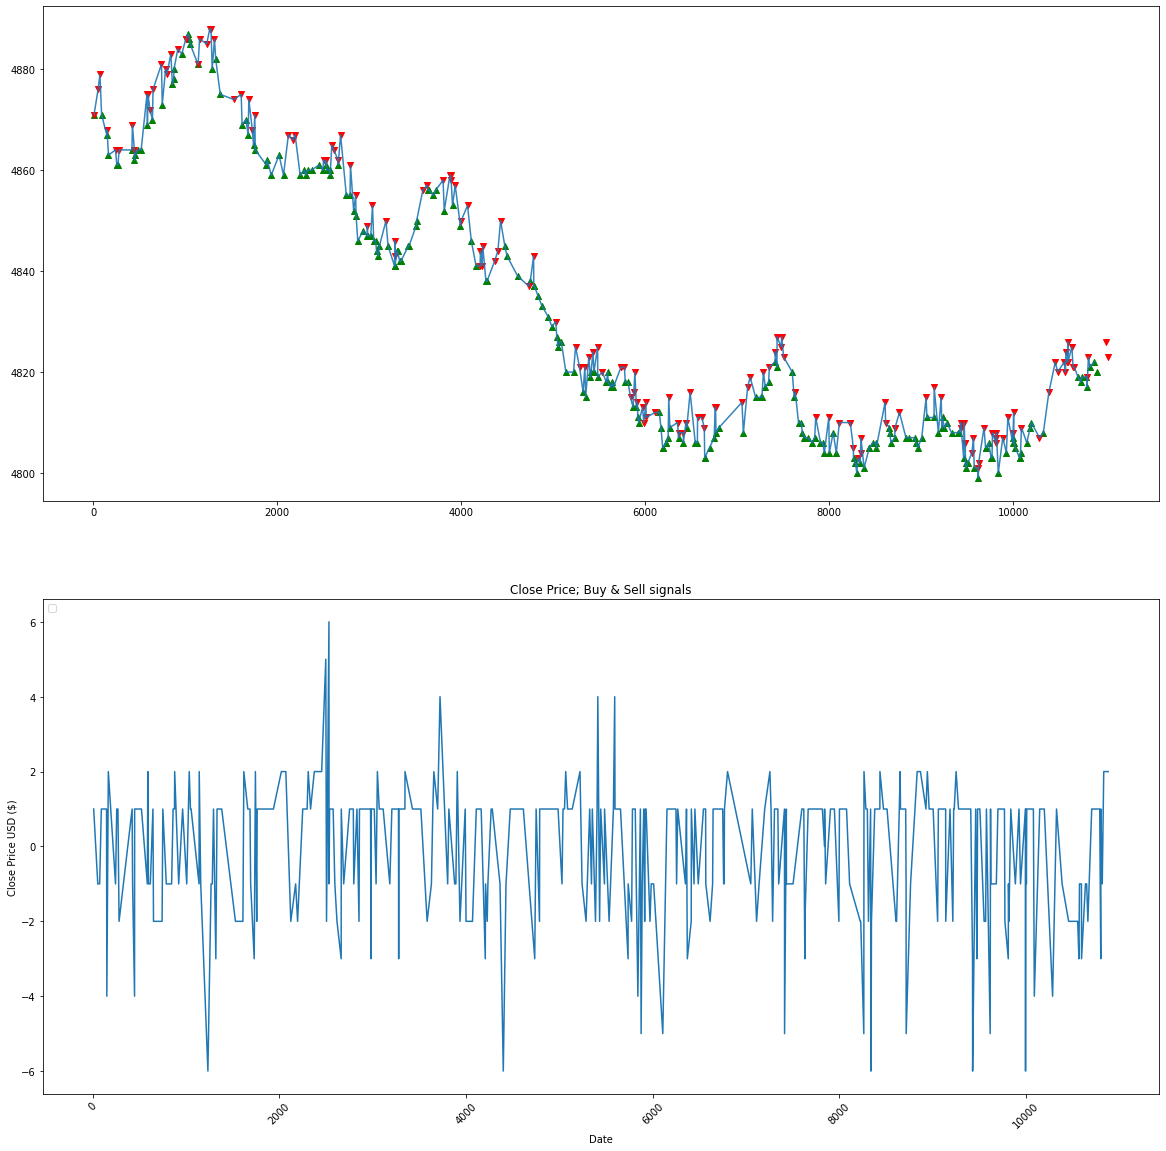

In [327]:
# fig = plt.figure(figsize=(20,12))
plt.rcParams["figure.figsize"] = [20,20]

fig, (ax1, ax2) = plt.subplots(2)
buys = temp[temp['buyer']==person]
sells = temp[temp['seller']==person]

min_index = min(sells.index[0],buys.index[0])
max_index = min(sells.index[-1],buys.index[-1])

temp_plot = temp[(temp.index >min_index) & (temp.index <max_index)]

ax1.scatter(buys.index, buys['price'],
            color='green', 
            label='Buy', 
            marker = '^', 
            alpha=1)

ax1.scatter(sells.index, sells['price'],
            color='red', 
            label='Sell', 
            marker = 'v', 
            alpha=1)

ax2.plot(temp_plot.index, temp_plot.apply(lambda x: -x['quantity'] if x['seller'] == person else x['quantity'],axis = 1))
ax1.plot(temp_plot['price'], label='Close Price', alpha = 0.9)
plt.title('Close Price; Buy & Sell signals')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend(loc='upper left')

plt.show()